In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem
from mas import MCTS, BinaryTree

sns.set()

# Assignment 1

---

The function for which we use MC sampling $f(x)=\sin^2(x)$

In [2]:
def f(x):
    return np.sin(x) ** 2

Using MC sampling by first drawing from a random distribution and using that to estimate $E(f(x))$.

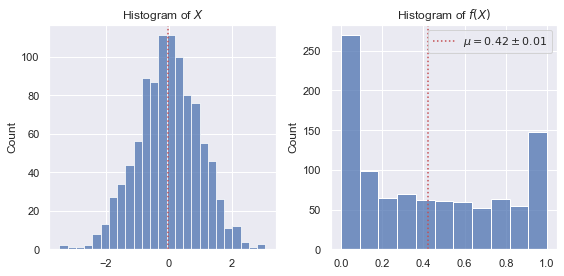

In [16]:
X = np.random.randn(1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(X, ax=ax1)
ax1.axvline(X.mean(), ls=":", c="r")
ax1.set_title("Histogram of $X$")

U = f(X)
sns.histplot(U, ax=ax2)
m = U.mean()
error = sem(U)
ax2.axvline(m, ls=":", c="r", label=f"$\mu={m:.2f} \pm {error:.2f}$")
ax2.set_title("Histogram of $f(X)$")
ax2.legend()

fig.tight_layout()
fig.savefig("1-1.pdf")

C:\Users\Alex Hoorn\miniconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Alex Hoorn\miniconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


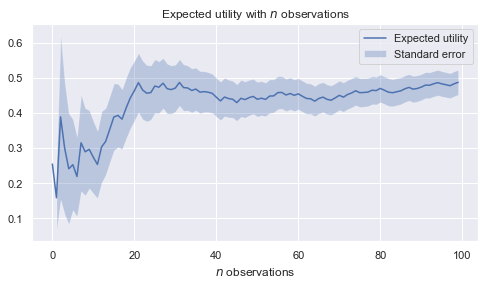

In [20]:
X = np.random.randn(100)
U = f(X)

E = np.array([U[: i + 1].mean() for i in range(len(U))])
error = np.array([sem(U[: i + 1]) for i in range(len(U))])

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(E, label="Expected utility")
ax.fill_between(range(len(E)), E - error, E + error, alpha=0.3, label="Standard error")
ax.legend()
ax.set_title("Expected utility with $n$ observations")
ax.set_xlabel("$n$ observations")

fig.savefig("1-2.pdf")

# Assignment 2

---

The binary tree we'll explore.

In [105]:
tree = BinaryTree(depth=12)
tree.get_best_reward()

(('R', 'L', 'L', 'R', 'R', 'R', 'R', 'L', 'L', 'R', 'L', 'R'),
 2.2973967099940698)

The Monte Carlo Tree Search algorithm.

In [106]:
mcts = MCTS(tree, verbose=True)
mcts.run()

Found reward=2.30 with path=('R', 'L', 'L', 'R', 'R', 'R', 'R', 'L', 'L', 'R', 'L', 'R') in 0.01s and 13 steps


Measuring the impact of c-parameter.

In [107]:
runtimes = []
steps = []
cs = []
rewards = []

for c in np.arange(0, 100, 1):
    mcts = MCTS(tree, c=c)
    mcts.run()

    runtimes.append(mcts.runtime)
    steps.append(mcts.search_steps)
    cs.append(c)
    rewards.append(mcts.reward)

Showing the impact of the c-parameter.

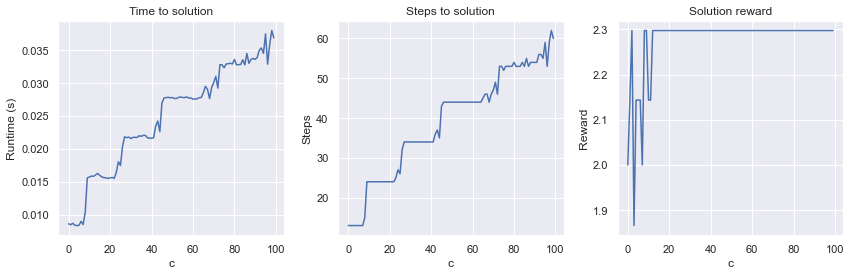

In [116]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

ax1.plot(cs, runtimes)
ax1.set_ylabel("Runtime (s)")
ax1.set_xlabel("c")
ax1.set_title("Time to solution")

ax2.plot(cs, steps)
ax2.set_ylabel("Steps")
ax2.set_xlabel("c")
ax2.set_title("Steps to solution")

ax3.plot(cs, rewards)
ax3.set_ylabel("Reward")
ax3.set_xlabel("c")
ax3.set_title("Solution reward")

fig.tight_layout()
fig.savefig("2-1.pdf")